# Урок 5. Сверточные нейронные сети

ЗАДАНИЕ 1.

Попробовать улучшить точность распознования образов cifar 10 сверточной нейронной сетью, рассмотренной на уроке. Приложить анализ с описанием того, что улучшает работу нейронной сети и что ухудшает.

In [6]:
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:

from __future__ import print_function
from numpy import asarray
import keras # расскоментируйте эту строку, чтобы начать обучение
from keras.datasets import cifar10
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.python.keras.optimizers import TFOptimizer
from keras import optimizers
import os

In [8]:
def create_evalute_model(batch_size,num_classes,epochs,data_augmentation,save_dir,model_name,target_dataset,
                         channels_array,inner_blocks_count,kernel_matrix):
    # разделение тренировочной и тестовой выборки
    (x_train, y_train), (x_test, y_test) = target_dataset.load_data()
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'тренировочные примеры')
    print(x_test.shape[0], 'тестовые примеры')

    # преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    # конфигурирование слоев нейросети
    model = Sequential()

    # слои нейросети отвественные за свертку и max-pooling
    model.add(Conv2D(32, kernel_matrix, padding='same',
                 input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, kernel_matrix))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    for i in range(inner_blocks_count):
        model.add(Conv2D(channels_array[i], kernel_matrix, padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(channels_array[i], kernel_matrix))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # инициализация RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # компиляция модели
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    if not data_augmentation:
        print('Не используется data augmentation')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Использование data augmentation в реальном времени')
        # Препроцессинг и data augmentation в реальном времени:
        datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False, 
            zca_epsilon=1e-06, 
            rotation_range=0, 
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0., 
            zoom_range=0., 
            channel_shift_range=0.,
            fill_mode='nearest',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=False,
            rescale=None,
            preprocessing_function=None,
            data_format=None,
            validation_split=0.0)

        # запуск data augmentation через fit
        #datagen.fit(x_train)

        # запуск data augmentation через fit_generator
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            workers=4)

    # сохранение модели и весов
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    #model.save(model_path)
    model.save(model_path,include_optimizer=False)
    print('сохранить обученную модель как %s ' % model_path)

    # проверка работы обученной модели
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    return scores[1]

In [9]:
# установка параметров нейросети
batch_size = 32
num_classes = 10
epochs = 1
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
target_dataset=cifar10
inner_blocks_count=1
channels_array=[64]
kernel_matrix=(3, 3)

In [5]:
accurancy=create_evalute_model(batch_size,num_classes,epochs,data_augmentation,save_dir,model_name,
                               target_dataset,channels_array,inner_blocks_count,kernel_matrix)
print('accurancy:',accurancy)

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Использование data augmentation в реальном времени
Epoch 1/1
1563/1563 [==============================] - 63s 41ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 215us/step
Test loss: nan
Test accuracy: 0.10000000149011612
accurancy: 0.10000000149011612


**Меняем параметр data_augmentations**

In [23]:
data_augmentations=[True,False]
accuracies=[]
for data_augmentation_par in data_augmentations:
    accurancy=create_evalute_model(batch_size,num_classes,epochs,data_augmentation_par,save_dir,model_name,
                               target_dataset,channels_array,inner_blocks_count,kernel_matrix)
    accuracies.append(accurancy)


x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Использование data augmentation в реальном времени
Epoch 1/1
1563/1563 [==============================] - 64s 41ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 219us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 63s 1ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 236us/step


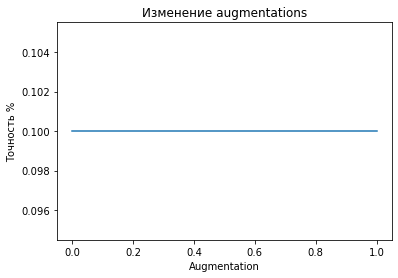

In [26]:
plt.plot(data_augmentations,accuracies)
plt.title("Изменение augmentations")
plt.xlabel('Augmentation')
plt.ylabel('Точность %')
plt.show()

**Вывод: точность не меняется от того, используем или нет мы augmentation**

In [18]:
data_augmentation=False

**Меняем параметр batch_sizes**

In [33]:

batch_sizes=[32,64,128]
accuracies=[]
for batch_size_par in batch_sizes:
    accurancy=create_evalute_model(batch_size_par,num_classes,epochs,data_augmentation,save_dir,model_name,
                               target_dataset,channels_array,inner_blocks_count,kernel_matrix)
    accuracies.append(accurancy)

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 58s 1ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 217us/step
Test loss: nan
Test accuracy: 0.10000000149011612
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 53s 1ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
1

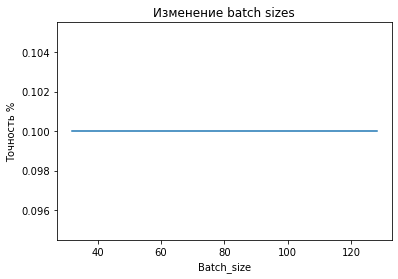

In [34]:
plt.plot(batch_sizes,accuracies)
plt.title("Изменение batch sizes")
plt.xlabel('Batch_size')
plt.ylabel('Точность %')
plt.show()

**Вывод: точность не меняется от того, какие batch_sizes мы используем**

**Меняем параметр epochs**

In [35]:
arr_epochs=[1,3,7]
accuracies=[]
for epochs_par in arr_epochs:
    accurancy=create_evalute_model(batch_size,num_classes,epochs_par,data_augmentation,save_dir,model_name,
                               target_dataset,channels_array,inner_blocks_count,kernel_matrix)
    accuracies.append(accurancy)

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 61s 1ms/step - loss: nan - accuracy: 0.1001 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 223us/step
Test loss: nan
Test accuracy: 0.10000000149011612
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 62s 1ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/3
50000/50000 [==============================] - 66s 1ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1

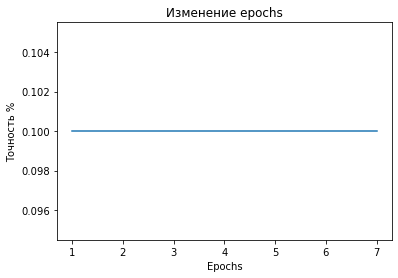

In [36]:
plt.plot(arr_epochs,accuracies)
plt.title("Изменение epochs")
plt.xlabel('Epochs')
plt.ylabel('Точность %')
plt.show()

**Вывод: точность не меняется от того, какие epochs мы используем**

**Меняем параметр inner_blocks_counts**

In [25]:
accuracies=[]
inner_blocks_counts=2
dict_channels_array={0:[64],1:[64,128]}

for inner_blocks_count_par in range(inner_blocks_counts):
    accurancy=create_evalute_model(batch_size,num_classes,epochs,data_augmentation,save_dir,model_name,
                                   target_dataset,dict_channels_array[inner_blocks_count_par],inner_blocks_count_par+1,kernel_matrix)
    accuracies.append(accurancy)

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 59s 1ms/step - loss: nan - accuracy: 0.1001 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 229us/step
Test loss: nan
Test accuracy: 0.10000000149011612
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 65s 1ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
1

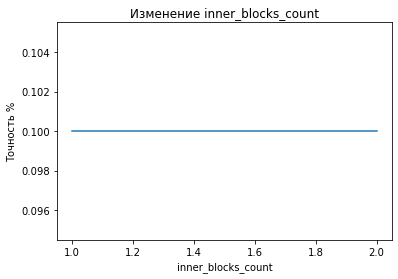

In [27]:
plt.plot([1,2],accuracies)
plt.title("Изменение inner_blocks_count")
plt.xlabel('inner_blocks_count')
plt.ylabel('Точность %')
plt.show()

**Вывод: точность не меняется от того, сколько внутренних слоев мы используем**

ЗАДАНИЕ 2

Описать также в анализе какие необоходимо внести изменения  в получившуюся у вас нейронную сеть если бы ей нужно было работать не с cifar10, а с MNIST, CIFAR100 и IMAGENET.

In [34]:
from keras.datasets import cifar100
target_dataset=cifar100
num_classes=100

In [35]:
accurancy=create_evalute_model(batch_size,num_classes,epochs,data_augmentation,save_dir,model_name,
                               target_dataset,channels_array,inner_blocks_count,kernel_matrix)
print('accurancy:',accurancy)

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 64s 1ms/step - loss: nan - accuracy: 0.0100 - val_loss: nan - val_accuracy: 0.0100
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 247us/step
Test loss: nan
Test accuracy: 0.009999999776482582
accurancy: 0.009999999776482582


**CIFAR100** 

**Для работы надо было изменить target_dataset=cifar100 и num_classes=100, однако точность уменьшилось в 10 раз и вероятно изменить ее в лучшую сторону изменяя параметры не получится**

IMAGENET не представляется возможным загрузить

In [75]:
from keras.datasets import mnist
target_dataset=mnist
num_classes=10

In [76]:
def create_evalute_model_ex(batch_size,num_classes,epochs,data_augmentation,save_dir,model_name,target_dataset,
                         channels_array,inner_blocks_count,kernel_matrix):
    # разделение тренировочной и тестовой выборки
    (x_train, y_train), (x_test, y_test) = target_dataset.load_data()
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'тренировочные примеры')
    print(x_test.shape[0], 'тестовые примеры')

    # преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2],1)
    x_test=x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
    # конфигурирование слоев нейросети
    model = Sequential()

    # слои нейросети отвественные за свертку и max-pooling
    model.add(Conv2D(32, kernel_matrix, padding='same',
                 input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, kernel_matrix))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    for i in range(inner_blocks_count):
        model.add(Conv2D(channels_array[i], kernel_matrix, padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(channels_array[i], kernel_matrix))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    # полносвязные слои нейронной сети
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # инициализация RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

    # компиляция модели
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    if not data_augmentation:
        print('Не используется data augmentation')
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True)
    else:
        print('Использование data augmentation в реальном времени')
        # Препроцессинг и data augmentation в реальном времени:
        datagen = ImageDataGenerator(
            featurewise_center=False,
            samplewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            zca_whitening=False, 
            zca_epsilon=1e-06, 
            rotation_range=0, 
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0., 
            zoom_range=0., 
            channel_shift_range=0.,
            fill_mode='nearest',
            cval=0.,
            horizontal_flip=True,
            vertical_flip=False,
            rescale=None,
            preprocessing_function=None,
            data_format=None,
            validation_split=0.0)

        # запуск data augmentation через fit
        #datagen.fit(x_train)

        # запуск data augmentation через fit_generator
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            workers=4)

    # сохранение модели и весов
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    #model.save(model_path)
    model.save(model_path,include_optimizer=False)
    print('сохранить обученную модель как %s ' % model_path)

    # проверка работы обученной модели
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    return scores[1]

In [77]:
accurancy=create_evalute_model_ex(batch_size,num_classes,epochs,data_augmentation,save_dir,model_name,
                               target_dataset,channels_array,inner_blocks_count,kernel_matrix)
print('accurancy:',accurancy)

x_train shape: (60000, 28, 28)
60000 тренировочные примеры
10000 тестовые примеры
Не используется data augmentation
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 57s 957us/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980
сохранить обученную модель как C:\Users\Windows\Documents\Introduction_to_Neural_Networks\saved_models\keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 2s 166us/step
Test loss: nan
Test accuracy: 0.09799999743700027
accurancy: 0.09799999743700027


**MNIST** 

**Для работы надо было изменить target_dataset=mnist и num_classes=10 и изменить размерность входного датасета, однако точность почти такая же 0.09799999743700027 и вероятно изменить ее в лучшую сторону изменяя параметры не получится**

**Вывод - модель не очень хорошего качества, вероятно надо строить другую модель, изменить например  optimizer**